In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
import numpy as np
import time

from pulsars import Pulsars, c, e_charge, e_mass
import speiser_fun as sf 
import speiser_fun_cyl as sfc
import speiser_integ as si
import speiser_plots as sp
import speiser_model as sm

In [2]:
k = 300.
name = 'crab'
pulsar = Pulsars(k)[name]


B_0 = pulsar['Blc']
gamma1 = 10**0
omegaB = (e_charge*B_0/(gamma1*e_mass*c))    #γυροσυχνότητα
Rlc = pulsar['rlc']*omegaB/c
Delta = pulsar['rlc']/k*omegaB/c

gamma0 = np.array([1.E+4, 1.])    #αρχικός παράγοντας Lorentz
delta = 1000.    #πάχος του φύλλου ρεύματος, αδιάστατο, σε μονάδες [c/ωΒ]

In [3]:
start_time = time.time()

T = 150.
dt = 6*10**4

(x1, ux1, y1, uy1, z1, uz1), dic_cart_noloss = si.oloklirosi(gamma0, Rlc, Delta, delta, B_0, T, dt, sm.speiser_cart_noloss, coord = 'cart')

# #λήξη χρονομέτρησης
elapsed = time.time() - start_time

print('total runtime for cartesian without losses = {:1.2E} s'.format(elapsed))

total runtime for cartesian without losses = 1.41E+01 s


In [4]:
start_time = time.time()

T = 150.
dt = 6*10**4

(x, ux, y, uy, z, uz), dic_cart_noloss = si.oloklirosi(gamma0, Rlc, Delta, delta, B_0, T, dt, sm.speiser_cart, coord = 'cart')

# #λήξη χρονομέτρησης
elapsed = time.time() - start_time

print('total runtime for cartesian with losses = {:1.2E} s\nexecuted at {}'.format(elapsed, start_time))

total runtime for cartesian with losses = 9.46E+01 s
executed at 1547574795.141632


In [5]:
start_time = time.time()

T = 30.
dt = 2*10**4

(r, ur, phi, uphi, z_cyl, uz_cyl), dic_cyl = si.oloklirosi(gamma0, Rlc, Delta, delta, B_0, T, dt, sm.speiser_cyl, coord = 'cyl')

# #λήξη χρονομέτρησης
elapsed = time.time() - start_time

print('total runtime for cylindrical with losses = {:1.2E} s'.format(elapsed))

total runtime for cylindrical with losses = 1.84E+02 s


In [6]:
start_time = time.time()

T = 30.
dt = 2*10**4

(r1, ur1, phi1, uphi1, z_cyl1, uz_cyl1), dic_cyl1 = si.oloklirosi(gamma0, Rlc, Delta, delta, B_0, T, dt, sm.speiser_cyl_noloss, coord = 'cyl')

# #λήξη χρονομέτρησης
elapsed = time.time() - start_time

print('total runtime for cylindrical without losses = {:1.2E} s'.format(elapsed))

total runtime for cylindrical without losses = 8.52E+00 s


In [7]:
start_time = time.time()

T = 45.
dt = 2*10**4

(r2, ur2, phi2, uphi2, z_cyl2, uz_cyl2), dic_cyl2 = si.oloklirosi(gamma0, Rlc, Delta, delta, B_0, T, dt, sm.speiser_cyl_Rlc, coord = 'cyl')

# #λήξη χρονομέτρησης
elapsed = time.time() - start_time

print('total runtime for cylindrical with explicit losses = {:1.2E} s'.format(elapsed))

total runtime for cylindrical with explicit losses = 3.06E+01 s


<IPython.core.display.Javascript object>


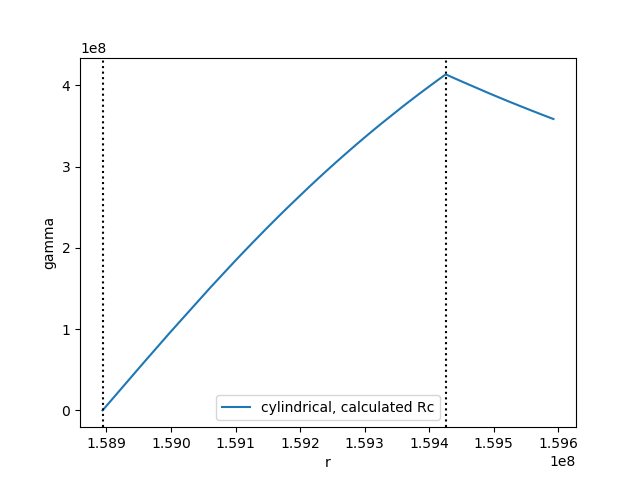

<IPython.core.display.Javascript object>


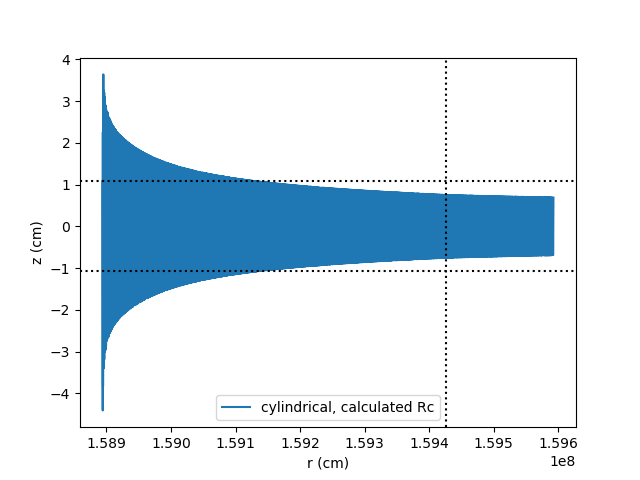

<IPython.core.display.Javascript object>


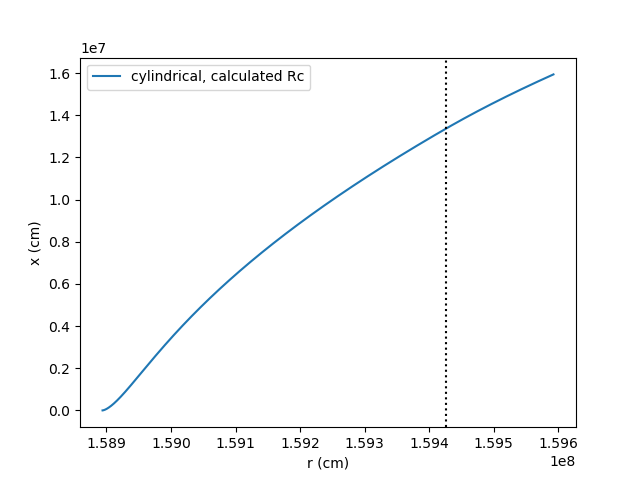

In [21]:
%matplotlib notebook

fig1 = plt.figure()
for i in range(0, len(r)-1):
#     plt.plot(z[i]*c/omegaB, sf.gamma(ux[i], uy[i], uz[i]), label = 'cartesian, calculated Rc')
#     plt.plot(z1[i]*c/omegaB, sf.gamma(ux1[i], uy1[i], uz1[i]), '--', label = 'cartesian, no losses')
    plt.plot(r[i]*c/omegaB, sf.gamma(ur[i], uphi[i], uz_cyl[i]), label = 'cylindrical, calculated Rc')
#     plt.plot(r2[i]*c/omegaB, sf.gamma(ur2[i], uphi2[i], uz_cyl2[i]), ':', label = 'cylindrical, Rc = Rlc')
#     plt.plot(r1[i]*c/omegaB, sf.gamma(ur1[i], uphi1[i], uz_cyl1[i]), '-.', label = 'cylindrical, no losses')
    # plt.yscale('log')
    plt.xlabel('r')
    plt.ylabel('gamma')
    # plt.axes('equal')
    plt.axvline(x = Rlc*c/omegaB, linestyle = ':', color = 'k')
    plt.axvline(x = (Rlc - Delta)*c/omegaB, linestyle = ':', color = 'k')
    plt.legend(loc = 'best')
    plt.text(0.5e5, 1.3e8,  'k = {:d}\n$\gamma_0$ = {:d}'.format(int(k), int(gamma0[i])))
#     fig1.savefig('γ(r)_k_{:d}.png'.format(int(k)))

fig2 = plt.figure()    
for i in range(0, len(r) - 1):
#     plt.plot(z[i]*c/omegaB, y[i]*c/omegaB, label = 'cartesian, calculated Rc')
#     plt.plot(z1[i]*c/omegaB, y1[i]*c/omegaB, '--', label = 'cartesian, no losses')
    plt.plot(r[i]*c/omegaB, z_cyl[i]*c/omegaB, label = 'cylindrical, calculated Rc')
#     plt.plot(r2[i]*c/omegaB, z_cyl2[i]*c/omegaB, ':', label = 'cylindrical, Rc = Rlc')
#     plt.plot(r1[i]*c/omegaB, z_cyl1[i]*c/omegaB, '--', label = 'cylindrical, no losses')
    plt.axhline(y = delta*c/omegaB, linestyle = ':', color = 'k')
    plt.axhline(y = -delta*c/omegaB, linestyle = ':', color = 'k')
    plt.axvline(x = Rlc*c/omegaB, linestyle = ':', color = 'k')
    plt.xlabel('r (cm)')
    plt.ylabel('z (cm)')
    plt.text(0.5e5, 0.75e0, 'k = {:d}\n$\gamma_0$ = {:d}'.format(int(k), int(gamma0[i])))
    plt.legend(loc = 'best')
#     fig2.savefig('epipedo_r-z_k_{:d}.png'.format(int(k))) 
    
fig3 = plt.figure()
for i in range(0, len(r) - 1):
#     plt.plot(z[i]*c/omegaB, x[i]*c/omegaB, label = 'cartesian, calculated Rc')
#     plt.plot(z1[i]*c/omegaB, x1[i]*c/omegaB, '--', label = 'cartesian, no losses')
    plt.plot(r[i]*c/omegaB, r[i]*np.sin(phi[i])*c/omegaB, label = 'cylindrical, calculated Rc')
#     plt.plot(r2[i]*c/omegaB, r2[i]*np.sin(phi2[i])*c/omegaB, ':', label = 'cylindrical, Rc = Rlc')
#     plt.plot(r1[i]*c/omegaB, r1[i]*np.sin(phi1[i])*c/omegaB, '--', label = 'cylindrical, no losses')
#     pac = mpatches.Arc([0, 0], Rlc - Delta, Rlc - Delta, angle=0, theta1=0, theta2=60)
#     plt.axes('equal')
#     plt.gca().add_patch(pac)
    plt.xlabel('r (cm)')
    plt.ylabel('x (cm)')
    # plt.title('Τροχιά στο επίπεδο r-z')
    plt.axvline(x = Rlc*c/omegaB, linestyle = ':', color = 'k')
    plt.legend(loc = 'best')
    plt.text(0.5e5, 3.8e6, 'k = {:d}\n$\gamma_0$ = {:d}'.format(int(k), int(gamma0[i])))
#     fig3.savefig('epipedo_r-rφ_k_{:d}.png'.format(int(k)))

plt.show()

In [9]:
urdot = [0]*len(ur)
uphidot = [0]*len(ur)
uz_cyldot = [0]*len(ur)
los = [0]*len(ur)
nu = [0]*len(ur)
r_curv = [0]*len(ur)


In [10]:
Frad_cyl = [0.]

In [11]:
for i in range(len(ur) - 1):
    
    for j in range(1, len(ur[i])):
        
        urdot[i] = np.zeros(len(ur[i]))
        uphidot[i] = np.zeros(len(ur[i]))
        uz_cyldot[i] = np.zeros(len(ur[i]))
        los[i] = np.zeros(len(ur[i]))
        nu[i] = np.zeros(len(ur[i]))
        r_curv[i] = np.zeros(len(ur[i]))
        
        urdot[i][j] = sfc.Flor_r(r[i][j], phi[i][j], z_cyl[i][j], ur[i][j], uphi[i][j], uz_cyl[i][j], Rlc, Delta, delta) - uphi[i][j]**2/(r[i][j]*sfc.gamma(ur[i][j], uphi[i][j], uz_cyl[i][j])) - Frad_cyl[-1]*ur[i][j]
        uphidot[i][j] = sfc.Flor_phi(r[i][j], phi[i][j], z_cyl[i][j], ur[i][j], uphi[i][j], uz_cyl[i][j], Rlc, Delta, delta) + ur[i][j]*uphi[i][j]/(r[i][j]*sfc.gamma(ur[i][j], uphi[i][j], uz_cyl[i][j])) - Frad_cyl[-1]*uphi[i][j]
        uz_cyl[i][j] = sfc.Flor_z_cyl(r[i][j], phi[i][j], z_cyl[i][j], ur[i][j], uphi[i][j], uz_cyl[i][j], Rlc, Delta, delta) - Frad_cyl[-1]*uz_cyl[i][j]
        
        nu[i][j] = sfc.nu_crit_curv(r[i][j], ur[i][j], uphi[i][j], uz_cyl[i][j], urdot[i][j], uphidot[i][j], uz_cyldot[i][j])
        
        r_curv[i][j] = sfc.Rc(r[i][j], ur[i][j], uphi[i][j], uz_cyl[i][j], urdot[i][j], uphidot[i][j], uz_cyldot[i][j])
        
        los[i][j] = sfc.Ploss(r[i][j], ur[i][j], uphi[i][j], uz_cyl[i][j], urdot[i][j], uphidot[i][j], uz_cyldot[i][j], B_0)
        
        Frad_cyl.append(sfc.F_rad(r[i][j], ur[i][j], uphi[i][j], uz_cyl[i][j], urdot[i][j], uphidot[i][j], uz_cyldot[i][j], B_0, sfc.Ploss))
    

<IPython.core.display.Javascript object>


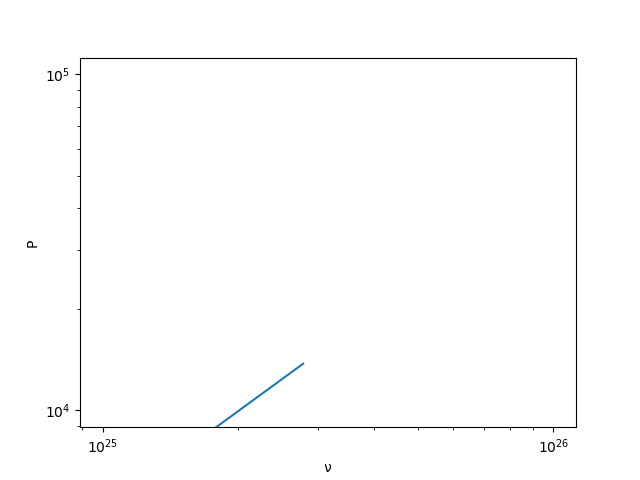

In [30]:
fig4 = plt.figure()
for i in range(0, len(r) - 1):
    plt.plot(nu[i], (B_0*c*e_charge)*los[i])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('ν')
    plt.ylabel('P')
plt.show()

In [13]:
print(start_time)

1547575082.5926313
